# <center>医学论文助手 - <b>M</b>edical <b>M</b>anuscript <b>Helper</b></center>

<b>说明</b>：仅适用于 <b>机器学习</b> - <b>监督学习</b> - <b>分类</b> 的医学论文

<b>操作</b>：点击 <b>菜单栏</b> - <b>Cell</b> - <b>Run All</b>，点击 <b>工具栏</b> - <b>眼睛</b> - <b>显示代码</b>

<b>注意</b>：
1. 查看结果需等待运行结束待机状态。右上角<b>Python 3</b>右侧圆圈 <b>空心</b> 待机状态， <b>实心</b> 正在运行。
2. Untrusted ==> Trusted, Javascript enabled for notebook display.

## 前言

- 本项目范例数据集基于：[Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data)
- 参考相关Kernels：[Feature Selection and Data Visualization](https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization) 和 [Intro to Keras with breast cancer data[ANN]](https://www.kaggle.com/thebrownviking20/intro-to-keras-with-breast-cancer-data-ann)

## 导入数据

<b>备注</b>：默认为当前目录下的data.xlsx文件，确认数据文件是否正确。

In [143]:
import pandas as pd
data = pd.read_excel('./pain.xlsx')
data

,pain,age,discharge,month,feed,invert,blood,lump,time
0,5,39,0,2,1,0,0,0,9
1,5,48,2,4,1,0,0,0,22
2,0,39,2,3,1,0,0,0,10
3,0,45,2,1,1,1,0,0,14
4,2,40,0,2,1,0,1,0,11
5,5,29,1,3,0,1,1,1,7
6,7,34,0,4,1,0,0,0,15
7,5,45,0,2,1,0,0,0,15
8,7,40,0,3,1,0,1,0,8
9,7,31,0,3,1,0,1,0,16


## 评估可行性

### 查看相关性

<b>备注</b>：注意有无有预测值高度相关的特征，红色正相关，蓝色负相关。

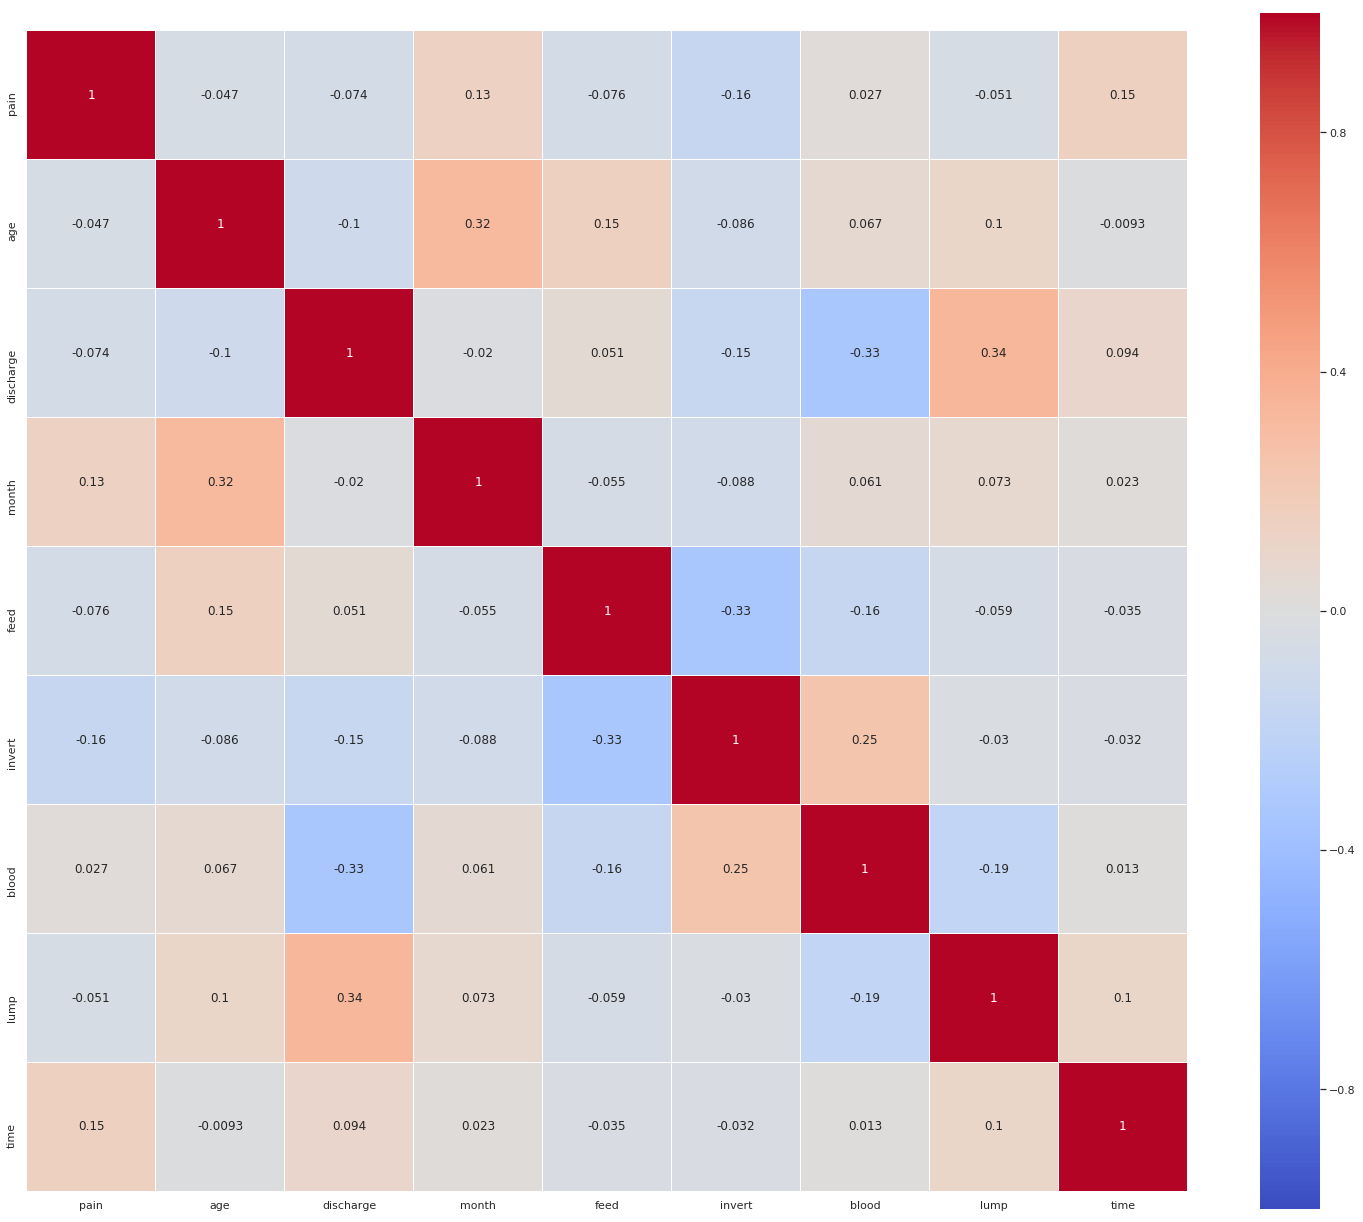

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(26, 22))
sns.heatmap(data.astype(float).corr(), linewidths=0.1, square=True,
            cmap='coolwarm', linecolor='white', annot=True, vmax=1, vmin=-1);

### 查看预测准确度

Note: Higher is Better.

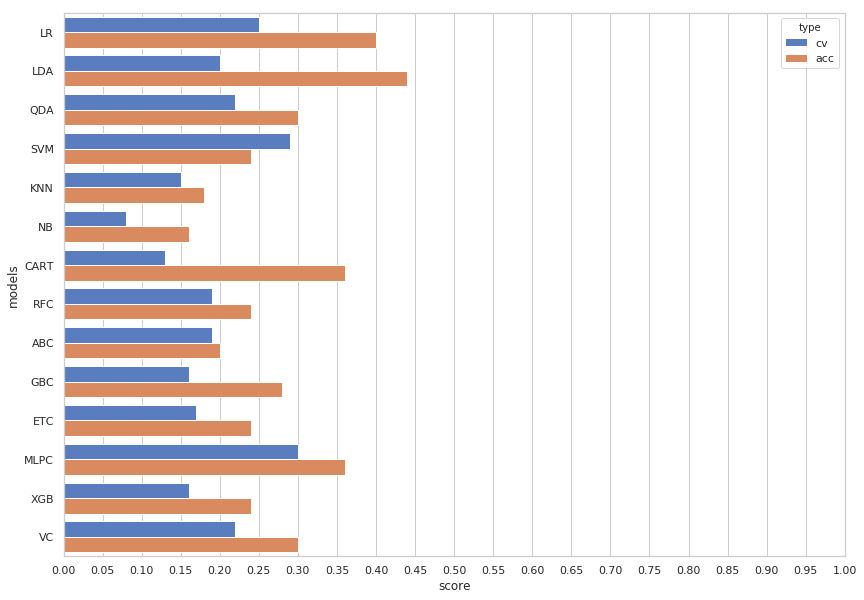

In [145]:
import numpy as np
import scipy.stats as scs

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

data = data.dropna()
X, y = data.values[:, 1:], data.values[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y)

# from sklearn.preprocessing import StandardScaler  
# scaler = StandardScaler()  
# # Don't cheat - fit only on training data
# scaler.fit(X_train)  
# X_train = scaler.transform(X_train)  
# # apply same transformation to test data
# X_test = scaler.transform(X_test)  

models = {
    'LR': LogisticRegression(solver='liblinear', multi_class='auto'),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'SVM': SVC(gamma='scale'),
    'KNN': KNeighborsClassifier(),
    'NB': GaussianNB(),
    'CART': DecisionTreeClassifier(),
    'RFC': RandomForestClassifier(n_estimators=100),
    'ABC': AdaBoostClassifier(),
    'GBC': GradientBoostingClassifier(),
    'ETC': ExtraTreesClassifier(n_estimators=100),
    'MLPC': MLPClassifier(),
    'XGB': XGBClassifier()
}

models['VC'] = VotingClassifier(estimators=[
    ('lr', models['LR']), ('lda', models['LDA']), ('qda', models['QDA']),
    ('svm', models['SVM']),('knn', models['KNN']), ('nb', models['NB']), 
    ('cart', models['CART']), ('rfc', models['RFC']), ('abc', models['ABC']),
    ('gbc', models['GBC']), ('etc', models['ETC']), ('mlpc', models['MLPC']),
    ('xgb', models['XGB'])], voting='hard')

kfold = StratifiedKFold(n_splits=10)
cv_result = []

for key in models:
        models[key].fit(X_train, y_train)
        cv_score = cross_val_score(
            models[key], X_train, y_train, scoring="accuracy", cv=kfold)
        cv_means = round(cv_score.mean(), 2)
    #     cv_std = round(cv_score.std(), 2)
        acc_score = round(models[key].score(X_test, y_test), 2)
        cvresult = {'models': key, 'score': cv_means, 'type': 'cv'}
        cv_result.append(cvresult)
        cvresult = {'models': key, 'score': acc_score, 'type': 'acc'}
        cv_result.append(cvresult)
    #     print(confusion_matrix(y_test, models[key].predict(X_test)))
    #     print(key)
    #     print('='*80)
    #     print(classification_report(y_test, models[key].predict(X_test)))
    #     print(key,'====',models[key].get_params())

cv_results = pd.DataFrame(cv_result)

plt.figure(figsize=(14, 10))
sns.set(style="whitegrid")
g = sns.barplot(x='score', y='models', hue='type', data=cv_results, palette="muted");
# g = sns.barplot(x='score', y='models', hue='type', data=cv_results, **{'xerr': cv_std})
g.set_xticks(np.arange(0, 1.05, 0.05));


### 学习曲线

Note: Case Number is Enough?

In [146]:
# Plotting Validation Curves todo

# def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, 
#                         train_sizes=np.linspace(.1, 1.0, 5)):
#     plt.figure()
#     plt.title(title)
#     if ylim is not None:
#         plt.ylim(*ylim)
#     plt.xlabel("Training examples")
#     plt.ylabel("Score")
#     train_sizes, train_scores, test_scores = learning_curve(
#         estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)
#     plt.grid()
#     plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.1,  color="r")
#     plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
#     plt.plot(train_sizes, train_scores_mean, 'o-',
#              color="r", label="Training score")
#     plt.plot(train_sizes, test_scores_mean, 'o-',
#              color="g", label="Cross-validation score")
#     plt.legend(loc="best")
#     return plt


# for key in models:
#     plot_learning_curve(models[key], key, X_train, y_train, cv=5)


### Feature Selection

Note: Feature enough or useful?

In [147]:
data.shape[1]

9

In [148]:
from sklearn.feature_selection import SelectKBest, chi2

X, y = data.values[:, 1:], data.values[:, 0]   
for i in range(1,data.shape[1]): 
    ch2=SelectKBest(chi2, k=i)
    X_f = ch2.fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_f, y)
    m_f = LogisticRegression(solver='liblinear', multi_class='auto')
    m_f.fit(X_train, y_train)
    cv_score = cross_val_score(m_f, X_train, y_train, scoring="accuracy", cv=kfold)
    cv_means = round(cv_score.mean(), 2)
    #     cv_std = round(cv_score.std(), 2)
    acc_score = round(m_f.score(X_test, y_test), 2)
    print(i, cv_means, acc_score)

1 0.27 0.26
2 0.21 0.22
3 0.24 0.14
4 0.33 0.26
5 0.31 0.28
6 0.31 0.24
7 0.25 0.38
8 0.29 0.28


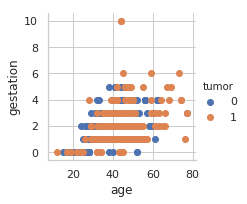

In [136]:
# For Age and Axillary nodes dect
sns.set_style('whitegrid')
sns.FacetGrid(data, hue='tumor', height=3) \
    .map(plt.scatter, 'age', 'gestation') \
    .add_legend()
plt.show()

## 提出问题

* 明确数据分析想解决或者了解的信息是什么？

## 理解数据

### 设定相关参数

In [72]:
# pd.set_option('precision', 2)  # 显示小数位数
# pd.set_option('max_rows', 11)  # 显示最大行数, describe需要11行
# pd.set_option('max_colwidth',40) # 最大列宽
# pd.reset_option('precision')  # 重置显示设置，其余选项类似
# %config InlineBackend.figure_format = 'svg'

### 数据基本信息

#### 查看数据基本结构

In [73]:
# dataframe.head()
# dataframe.head(), dataframe.tail(), dataframe.index, dataframe.columns, dataframe.values
# dataframe.T  # 行列互换
# dataframe.sort_values(by='age')  # 按列值排序
# dataframe[dataframe.age < 35]  # 按条件查看数据

In [74]:
# dataframe['distance'] = dataframe['distance'].fillna('1.0')
# dataframe['size'] = dataframe['size'].fillna('1.0')
# X_train = dataframe.drop('group', axis=1)
# y_train = dataframe['group']
# from sklearn.linear_model import LogisticRegression
# logreg = LogisticRegression()
# logreg.fit(X_train, y_train)
# acc_log = round(logreg.score(X_train, y_train) * 100, 2)
# logreg.coef_[0]

#### 设定数据类型

In [75]:
# dataframe[['group', 'menopause', 'gestation', 'pain', 'ectasia', 'multiple', 'distance', 'size']] = dataframe[[
#     'group', 'menopause', 'gestation', 'pain', 'ectasia', 'multiple', 'distance', 'size']].astype('category')
# category, int64, float64, datetime64, object
# dataframe.info()
# 确认数据结构

#### 数据基本统计信息

In [76]:
# dataframe.describe(include='all')

In [77]:
# dataframe.age.describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9, .99])

In [78]:
# dataframe.hist(grid=False, bins=20, figsize=(10,10), layout=(3,3));

---

#### 查看指定数据

In [79]:
# dataframe['group'].value_counts()
# dataframe.groupby('group').mean()
# dataframe[dataframe.age > 70]
# dataframe[['size','group']].groupby('size').mean()

* 数据相关性

In [80]:
# dataframe.corr(method='spearman')
# 'pearson', 'kendall', 'spearman'

* 分组情况（按第一列分组）

In [81]:
# chisq = data.groupby([data['group'], data['gestation']]).size()
# print(chisq)

In [82]:
# pd.crosstab(dataframe['group'], dataframe['gestation'], margins=True)

* 卡方检验（2*2表格）
    - 所有的理论数T≥5并且总样本量n≥40，用Pearson卡方进行检验。
    - 如果理论数T＜5但T≥1，并且1≥40，用连续性校正的卡方进行检验。
    - 如果有理论数T＜1或n＜40，则用Fisher’s检验。
    - 非2*2表格直接使用stats.chi2_contingency(chisq_matrix)

* R×C表卡方检验应用条件：
    - R×C表中理论数小于5的格子不能超过1／5；
    - 不能有小于1的理论数。如果实验中有不符合R×C表的卡方检验，可以通过增加样本数、列合并来实现。

In [83]:
# chisq_matrix = np.array([[chisq[0, 0], chisq[0, 1]],
#                          [chisq[1, 0], chisq[1, 1]]])
# stats.chi2_contingency(chisq_matrix, correction=False)  # Pearson
# stats.chi2_contingency(chisq_matrix) # 连续性校正
# stats.fisher_exact(chisq_matrix)

### 数据可视化

In [84]:
# g = sns.FacetGrid(dataframe, col='group')
# g.map(plt.hist, 'age',bins=20)

In [85]:
# grid = sns.FacetGrid(dataframe, col='group', row='menopause')
# grid.map(plt.hist, 'age', bins=20)
# grid.add_legend();

In [86]:
# grid = sns.FacetGrid(dataframe, row='menopause')
# grid.map(sns.pointplot, 'gestation', 'group', 'ectasia', palette='deep')
# grid.add_legend()

* 单变量密度图

In [87]:
# data.plot(
#     kind='density',
#     subplots=True,
#     figsize=(10, 10),
#     layout=(3, 3),
#     sharex=False)

* 单变量箱图

In [88]:
# data.plot(
#     kind='box', subplots=True, figsize=(10, 10), layout=(3, 3), sharex=False)

* 多变量相关矩阵图

In [89]:
# import numpy as np
# correlations = data.corr()
# fig = pyplot.figure()
# ax = fig.add_subplot('111')
# ax.matshow(correlations, vmin=-1, vmax=1)
# ticks = np.arange(0, 9, 1)
# ax.set_xticks(ticks)
# ax.set_yticks(ticks)
# ax.set_xticklabels(data.columns)
# ax.set_yticklabels(data.columns)
# fig.set_size_inches(10, 10)

* 散点矩阵图

In [90]:
# pd.plotting.scatter_matrix(data, figsize=(15,15));

### 数据预处理

* 数据缺失值处理

In [91]:
# data = dataframe.dropna()

* 分离数据

In [92]:
# from sklearn.model_selection import train_test_split
# array = data.values
# X = array[:, 1:]
# y = array[:, 0]

1. 调整尺度

In [93]:
# from sklearn.preprocessing import MinMaxScaler
# transformer = MinMaxScaler(feature_range=(0,1))
# X = transformer.fit_transform(X)

2. 正态化数据

In [94]:
# from sklearn.preprocessing import StandardScaler
# transformer = StandardScaler().fit(X)
# X = transformer.transform(X)

3. 标准化数据

In [95]:
# from sklearn.preprocessing import Normalizer
# transformer = Normalizer().fit(X)
# X = transformer.transform(X)

4. 二值数据

In [96]:
# from sklearn.preprocessing import Binarizer
# transformer = Binarizer().fit(X)
# X = transformer.transform(X)

### 特征选择

* 单变量特征选择

In [97]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2
# testchi = chi2(X, Y)
# test = SelectKBest(score_func=chi2, k=2)
# fit = test.fit(X, Y)
# print(fit.scores_)
# features = fit.transform(X)
# test.get_support()

* 递归特征消除（RFE）

In [98]:
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression
# model = LogisticRegression(solver='lbfgs')
# rfe = RFE(model, 3)
# fit = rfe.fit(X, Y)
# print(fit.n_features_)
# print(fit.support_)
# print(fit.ranking_)

* 主要成分分析（PCA）

In [99]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=3)
# fit = pca.fit(X)
# print(fit.explained_variance_ratio_)
# print(fit.components_)

* 特征重要性

In [100]:
# from sklearn.ensemble import ExtraTreesClassifier
# model = ExtraTreesClassifier(n_estimators=100)
# fit = model.fit(X, Y)
# print(fit.feature_importances_)

### 评估算法

* 数据分组

In [101]:
# testsize = 0.2
# seed = 4
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=testsize, random_state=seed)

* 评估模型

In [102]:
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score

# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC

# from xgboost import XGBClassifier

# models = {}
# models['LR'] = LogisticRegression(solver='liblinear')
# models['LDA'] = LinearDiscriminantAnalysis()
# models['KNN'] = KNeighborsClassifier()
# models['CART'] = DecisionTreeClassifier()
# models['NB'] = GaussianNB()
# models['SVM'] = SVC(gamma='scale')
# models['XGB'] = XGBClassifier()

# results = []
# for key in models:
#     kfold = KFold(n_splits=10, random_state=seed)
#     cv_results = cross_val_score(
#         models[key], X_train, y_train, cv=kfold, scoring='accuracy')
#     results.append(cv_results)


* 箱图比较算法

In [103]:
# plt.boxplot(results);

### 预测

In [104]:
# svm = SVC(gamma='scale')
# svm.fit(X=X_train, y=y_train)
# predictions = svm.predict(X_test)
# models['XGB'].fit(X_train, y_train)
# predictions = models['XGB'].predict(X_test)

In [105]:
# accuracy_score(y_test, predictions)

In [106]:
# confusion_matrix(y_test, predictions)

In [107]:
# print(classification_report(y_test, predictions))

In [108]:
# Probability calibration